In [1]:
import os
import torch
import numpy as np
from torch import nn
from relaxed_gconv import TranSymDisNet
from utils import get_lr, DatasetFluid2D, train_model_batch
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Discovering Translation Symmetry Breaking

In [2]:
in_channels = 2
out_channels = 2
kernel_size = 3
h_size = 256
w_size = 128
hidden_dim = 16
num_filter_basis = 1
batch_size = 128
learning_rate = 0.001
decay_rate = 0.9
num_epoch = 100
train_indices = np.arange(0, 1800)
valid_indices = np.arange(1800, 2000)

all_equiv_errors_seeds = []
for seed in range(5):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    data_direc = "data/fluid/Re_180_1.npy"

    train_set = DatasetFluid2D(direc = data_direc, sample_list = train_indices)
    valid_set = DatasetFluid2D(direc = data_direc, sample_list = valid_indices)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = False, num_workers = 2)   


    model = TranSymDisNet(in_channels = in_channels, 
                          out_channels = out_channels, 
                          kernel_size = kernel_size, 
                          h_size = h_size, 
                          w_size = w_size, 
                          hidden_dim = hidden_dim, 
                          num_filter_basis = num_filter_basis).to(device)

    best_model = train_model_batch(model, train_loader, valid_loader, num_epoch, learning_rate, decay_rate)
    learnt_relaxed_weights = torch.stack([model.model[i].relaxed_weights[:,:,0] for i in range(3)]).cpu().data.numpy()
    # Normalize relaxed weights for every height/y-coordinate
    learnt_relaxed_weights = (learnt_relaxed_weights - learnt_relaxed_weights.min((2), keepdims = True))/(learnt_relaxed_weights.max((2), keepdims = True) - learnt_relaxed_weights.min((2), keepdims = True))
    # Calculate the equivariance error based on the learnt relaxed weights
    # \sum_{g \in G} |w(e) - w(g)|
    equiv_error_y = np.mean(np.abs(learnt_relaxed_weights - learnt_relaxed_weights[:,:,63:64]), axis = -1).mean(0)
    all_equiv_errors_seeds.append(equiv_error_y)

std_equiv_error = np.std(all_equiv_errors_seeds, axis = 0)
avg_equiv_error = np.mean(all_equiv_errors_seeds, axis = 0)

Epoch 1 | T: 0.04 | Train MAE: 0.19983 | Valid MAE: 0.12576 | LR 0.000900
Epoch 11 | T: 0.03 | Train MAE: 0.00093 | Valid MAE: 0.00088 | LR 0.000314
Epoch 21 | T: 0.03 | Train MAE: 0.00048 | Valid MAE: 0.00047 | LR 0.000109
Epoch 31 | T: 0.03 | Train MAE: 0.00039 | Valid MAE: 0.00039 | LR 0.000038
Epoch 41 | T: 0.03 | Train MAE: 0.00037 | Valid MAE: 0.00037 | LR 0.000013
Epoch 51 | T: 0.03 | Train MAE: 0.00036 | Valid MAE: 0.00036 | LR 0.000005
Epoch 1 | T: 0.03 | Train MAE: 0.08947 | Valid MAE: 0.00700 | LR 0.000900
Epoch 11 | T: 0.03 | Train MAE: 0.00080 | Valid MAE: 0.00076 | LR 0.000314
Epoch 21 | T: 0.03 | Train MAE: 0.00038 | Valid MAE: 0.00038 | LR 0.000109
Epoch 31 | T: 0.03 | Train MAE: 0.00027 | Valid MAE: 0.00027 | LR 0.000038
Epoch 41 | T: 0.03 | Train MAE: 0.00024 | Valid MAE: 0.00024 | LR 0.000013
Epoch 51 | T: 0.03 | Train MAE: 0.00023 | Valid MAE: 0.00023 | LR 0.000005
Epoch 1 | T: 0.03 | Train MAE: 0.20293 | Valid MAE: 0.11221 | LR 0.000900
Epoch 11 | T: 0.03 | Train M

## 2. Visualize the equiv error along Y axis

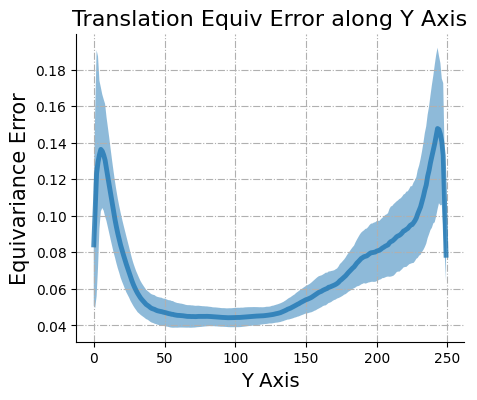

<Figure size 640x480 with 0 Axes>

In [3]:
fig=plt.figure(figsize=(5, 4))
# remove boundary effects
avg_equiv_error = avg_equiv_error[3:-3]
std_equiv_error = std_equiv_error[3:-3]
plt.plot(avg_equiv_error,  linewidth = 3.5,  alpha=.8)
plt.fill_between(np.arange(len(avg_equiv_error)), (avg_equiv_error-std_equiv_error), (avg_equiv_error+std_equiv_error), alpha=.5)
plt.ylabel("Equivariance Error", size = 15)
plt.xlabel("Y Axis", size = 14)
plt.title("Translation Equiv Error along Y Axis", size = 16)
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(1)   
plt.grid(True, linestyle='-.')
plt.show()
plt.savefig("translation_equiv.png", dpi = 200, bbox_inches = 'tight')